In [1]:
from pyDACP import core
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.linalg import eigh
from scipy.sparse import eye, diags
import math
from scipy.linalg.lapack import zlarf, zlarfg

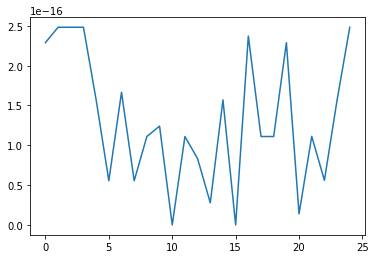

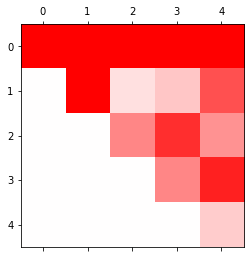

In [2]:
#M = np.random.rand(4, 2) + np.random.rand(4, 2)*1j
#M = np.concatenate((M, M), axis=1)
M = np.random.rand(5, 5) + np.random.rand(5, 5)*1j
M = np.array(M, dtype=np.complex128)

r = np.copy(M)
N = np.min(np.shape(M))
Q = np.eye(N)
P = np.eye(N)
for i in range(N):
    vec = M[:, i]
    vec = Q.T.conj() @ vec
    beta, v, tau = zlarfg(N-i, vec[i], vec[i+1:])
    v = np.array([1, *v])
    P_sub = np.eye(N - i) - tau*np.outer(v, v.conj().T)
    P = scipy.linalg.block_diag(np.eye(i), P_sub)
    r = P.T.conj() @ r
    Q = Q @ P
plt.plot(np.abs(Q @ r - M).flatten())
plt.show()
plt.matshow(np.abs(r), vmin=-1, vmax=1, cmap='bwr')

In [22]:
def basis(v_proj, matrix, indices):
    count = 0
    N = matrix.shape[0]
    Q = np.eye(N)
    # TODO: If k is too large, the norms of the vectors are from some large order.
    k = indices[-1]
    for i in range(k+1):
        if i == 0:
            v_n = v_proj
        elif i == 1:
            v_nm1 = v_n
            v_n = matrix @ v_nm1
        else:
            v_np1 = 2 * matrix @ v_n - v_nm1
            v_nm1 = v_n
            v_n = v_np1
        if i in indices:
            v_n_hh = v_n/np.linalg.norm(v_n)
            vec = Q.T.conj() @ v_n_hh
            print(vec[count])
            if np.abs(vec[count]) < 1e-9:
                print('Ended with ' + str(count) + ' vectors.')
                basis = Q[:, :count]
                return basis/(np.linalg.norm(basis, axis=0))
            beta, v_orth, tau = zlarfg(N-count, vec[count], vec[count+1:])
            v_orth = np.array([1, *v_orth])
            P_sub = np.eye(N - count) - tau * np.outer(v_orth, v_orth.T.conj())
            P = scipy.linalg.block_diag(np.eye(count), P_sub)
            Q = Q @ P
            count += 1
    basis = Q[:, :count]
    return basis/(np.linalg.norm(basis, axis=0))

In [27]:
# +
N = 500
a = 0.1
c = 1e-10 * (np.random.rand(N-1) + np.random.rand(N-1)*1j)
b = np.random.rand(N)
H = diags(c, offsets=-1) + diags(b, offsets=0) + diags(c.conj(), offsets=1)
# b = np.linspace(-1, 1, N)
# H = diags(b, offsets=0)


dacp=core.DACP_reduction(H, a=a, eps=0.1, bounds=None, sampling_subspace=5)
dacp.estimate_subspace_dimenstion()

v_proj=dacp.get_filtered_vector()
d = dacp.estimate_subspace_dimenstion()
print(d)
n = math.ceil(np.abs((d*dacp.sampling_subspace - 1)/2))
a_r = dacp.a / np.max(np.abs(dacp.bounds))
n_array = np.arange(1, n+1, 1)
indicesp1 = (n_array*np.pi/a_r).astype(int)
indices = np.sort(np.array([*indicesp1, *indicesp1-1]))
vbasis=basis(v_proj=v_proj, matrix=dacp.G_operator(), indices=indices)
S = vbasis.conj().T@vbasis
plt.matshow(np.abs(S) - np.eye(np.shape(S)[0]))
plt.colorbar()

ValueError: cannot convert float NaN to integer

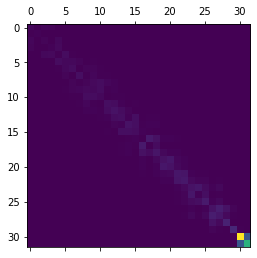

In [24]:
H_red = vbasis.T.conj() @ H @ vbasis
plt.matshow(np.abs(H_red))

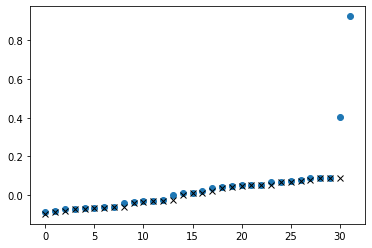

In [25]:
plt.plot(eigh(H_red, eigvals_only=True), 'o')
true_eig = eigh(H.todense(), eigvals_only=True)
idx = np.abs(true_eig) < 0.1
plt.plot(true_eig[idx], 'x', c='k')
# plt.ylim(-a, a)

In [7]:
b = np.linspace(-1, 1, N)
H = diags(b, offsets=0)

In [8]:
q,r=np.linalg.qr(H.todense())

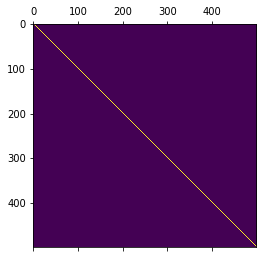

In [9]:
plt.matshow(q)

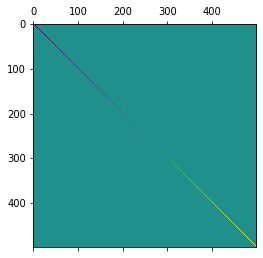

In [107]:
plt.matshow(r)